# Linear fit using maximum likelihood

This notebook introduces how to perform linear fit with the maximum likelihood method.  
**Author:** Bill Chen  
**Created:** July 2022  
**Last modified:** July 2022  
**License:** MIT  
**Modules:**
```
python = 3.8.3
numpy = 1.18.5
matplotlib = 3.4.3
scipy = 1.7.3
```

## Linear fit with x error, y error, and instrinsic scatter

We write the model in the following form:

$$
y = a + bx \pm \sigma.
$$

We want to maximize the Gaussuan likelihood function:

$$
{\cal L} = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}}\exp\left(-\frac{\delta_i^2}{2\sigma_i^2}\right)
$$

where $\delta_i = y-a-bx$ and $\sigma_i^2 = b\sigma_x^2 + \sigma_y^2 + \sigma^2$, $\sigma_x$ and $\sigma_y$ are the observational error of $x$ and $y$. ${\cal L}$ is normally very small for large number of data. And, minimization can be more easily done with computers. So, we change the maximum likelihood problem to the manimum negative-log-likelihood problem:


$$
-\log{\cal L} = \sum_{i=1}^N \left(-\frac{1}{2}\log(2\pi)+\frac{1}{2}\log\sigma_i+\frac{\delta_i^2}{2\sigma_i^2}\right)
= \frac{1}{2}\sum_{i=1}^N \left(\log\sigma_i+\frac{\delta_i^2}{\sigma_i^2}\right) -\frac{N}{2}\log(2\pi)
$$

That is, we only need to minimize

$$
\sum_{i=1}^N \left(\log\sigma_i+\frac{\delta_i^2}{\sigma_i^2}\right)
$$

In [1]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def neg_log_gaussian_likelihood(p, x, y, dx, dy):
    '''
    negative log of Gaussuan likelihood
    '''
    a = p[0]
    b = p[1]
    sig = p[2]
    sigi2 = sig**2 + dy**2 + (b*dx)**2
    return np.sum(np.log(sigi2) + (y-a-b*x)**2/sigi2)

def neg_log_ortho_likelihood(p, xb, yb, dxb, dyb):
    '''
    negative log of Orthogonal likelihood
    '''
    a = p[0]
    b = p[1]
    t = np.arctan(b)
    sig2 = p[2]**2*np.cos(t)**2
    D2 = ((yb - a)*np.cos(t) - xb*np.sin(t))**2
    S2 = dyb**2*np.cos(t)**2 + dxb**2*np.sin(t)**2
    return np.sum(np.log(S2+sig2)) + np.sum(D2/(S2+sig2))

def linear_fit_maxlike(x, y, dx, dy):
    bnds = ((None, None), (None, None), (0, None))
    o = minimize(neg_log_ortho_likelihood, [1.,0.,1.], args=(x,y,dx,dy), bounds=bnds)
    return o.x

def linear_fit_maxlike_boot(x, y, dx, dy, size=100):
    data = np.column_stack((x, y, dx, dy))
    data_boot = data[np.random.randint(0, len(x), (size, len(x)))]
    
    a_list = np.zeros(size)
    b_list = np.zeros(size)
    sig_list = np.zeros(size)
    
    for i, d in enumerate(data_boot):
        bnds = ((None, None), (None, None), (0, None))
        o = minimize(neg_log_ortho_likelihood, [1.,0.,1.], 
            args=(d[:,0],d[:,1],d[:,2],d[:,3]), bounds=bnds)
        a_list[i] = o.x[0]
        b_list[i] = o.x[1]
        sig_list[i] = o.x[2]
        
    return a_list, b_list, sig_list

In [2]:
# generate test data

np.random.seed(0)

N_samp = 100

a_true = 0
b_true = 1
sig_true = 2
dx = 1*np.ones(N_samp) # observational error
dy = 1*np.ones(N_samp) 

x = 5*np.random.normal(size=N_samp)
x = 30*np.random.rand(N_samp) - 15
y = a_true + b_true*x + sig_true*np.random.normal(size=N_samp)

# add observational error
x = x + dx*np.random.normal(size=N_samp)
y = y + dy*np.random.normal(size=N_samp)

In [3]:
a, b, sig = linear_fit_maxlike_boot(x, y, dx, dy, 1000)
print('a_true = %.3f, a = %.3f +- %.3f'%(a_true, np.mean(a), np.std(a)))
print('b_true = %.3f, b = %.3f +- %.3f'%(b_true, np.mean(b), np.std(b)))
print('sig_true = %.3f, sig = %.3f +- %.3f'%(sig_true, np.mean(sig), np.std(sig)))

a_true = 0.000, a = -0.358 +- 0.260
b_true = 1.000, b = 1.033 +- 0.032
sig_true = 2.000, sig = 2.027 +- 0.224


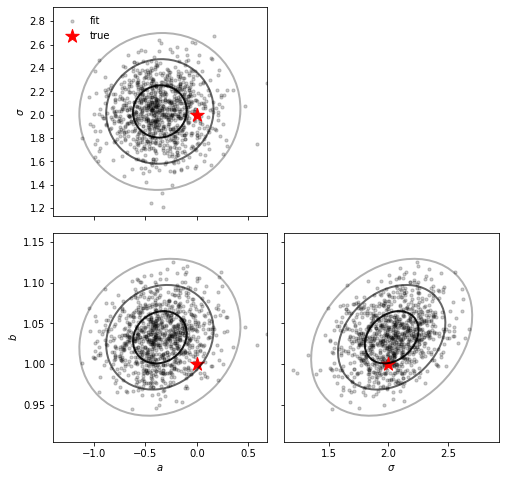

In [4]:
# visualization

def confidence_ellipse(ax, x, y, n_std=3.0, facecolor='none', **kwargs):
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig = plt.figure(figsize=(8,8))
ax0 = plt.subplot2grid((2, 2), (1, 0))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))
fig.subplots_adjust(hspace=0.08, wspace=0.08)

# bootstrap results
ax0.scatter(a, b, c='k', s=10, alpha=0.2)
confidence_ellipse(ax0, a, b, 1, ec='k', lw=2, alpha=0.9)
confidence_ellipse(ax0, a, b, 2, ec='k', lw=2, alpha=0.6)
confidence_ellipse(ax0, a, b, 3, ec='k', lw=2, alpha=0.3)
ax1.scatter(a, sig, c='k', s=10, alpha=0.2, label='fit')
confidence_ellipse(ax1, a, sig, 1, ec='k', lw=2, alpha=0.9)
confidence_ellipse(ax1, a, sig, 2, ec='k', lw=2, alpha=0.6)
confidence_ellipse(ax1, a, sig, 3, ec='k', lw=2, alpha=0.3)
ax2.scatter(sig, b, c='k', s=10, alpha=0.2)
confidence_ellipse(ax2, sig, b, 1, ec='k', lw=2, alpha=0.9)
confidence_ellipse(ax2, sig, b, 2, ec='k', lw=2, alpha=0.6)
confidence_ellipse(ax2, sig, b, 3, ec='k', lw=2, alpha=0.3)

# true values
ax0.scatter(a_true, b_true, c='r', marker='*', s=200, alpha=1)
ax1.scatter(a_true, sig_true, c='r', marker='*', s=200, alpha=1, label='true')
ax2.scatter(sig_true, b_true, c='r', marker='*', s=200, alpha=1)

# plot parameters
ax0.set_xlabel(r'$a$')
ax2.set_xlabel(r'$\sigma$')
ax0.set_ylabel(r'$b$')
ax1.set_ylabel(r'$\sigma$')
ax0.set_xlim(np.mean(a)-4*np.std(a), np.mean(a)+4*np.std(a))
ax1.set_xlim(np.mean(a)-4*np.std(a), np.mean(a)+4*np.std(a))
ax1.set_xticklabels([])
ax0.set_ylim(np.mean(b)-4*np.std(b), np.mean(b)+4*np.std(b))
ax2.set_ylim(np.mean(b)-4*np.std(b), np.mean(b)+4*np.std(b))
ax2.set_yticklabels([])
ax2.set_xlim(np.mean(sig)-4*np.std(sig), np.mean(sig)+4*np.std(sig))
ax1.set_ylim(np.mean(sig)-4*np.std(sig), np.mean(sig)+4*np.std(sig))

ax1.legend(frameon=False, loc='upper left')
plt.show()

In [5]:
def plot_linear_fit_with_error(ax, xmin, xmax, xmean, ymean, a, da, b, db, sig, dsig, **kwargs):
    
    x = np.linspace(xmin, xmax, 100+1)
    y = a+b*(x-xmean)+ymean
    dy = np.sqrt(sig**2 + da**2 + (db*(x-xmean))**2)
    return ax.fill_between(x, y-dy, y+dy, **kwargs)
    
#     if (xmin < xmean) & (xmean < xmax):
#         ax.fill_between([xmin,xmean], 
#             [(a+b*(xmin-xmean)-da-db*(xmean-xmin)-sig-dsig+ymean), (a-da-sig-dsig+ymean)], 
#             [(a+b*(xmin-xmean)+da+db*(xmean-xmin)+sig+dsig+ymean), (a+da+sig+dsig+ymean)], 
#             **kwargs)
#         return ax.fill_between([xmean,xmax],
#             [(a-da-sig-dsig+ymean), (a+b*(xmax-xmean)-da-db*(xmax-xmean)-sig-dsig+ymean)], 
#             [(a+da+sig+dsig+ymean), (a+b*(xmax-xmean)+da+db*(xmax-xmean)+sig+dsig+ymean)],
#             **kwargs)
#     else:
#         return ax.fill_between([xmin,xmax], 
#             [(a+b*(xmin-xmean)-da-abs(db*(xmean-xmin))-sig-dsig+ymean), 
#                 (a+b*(xmax-xmean)-da-abs(db*(xmax-xmean))-sig-dsig+ymean)], 
#             [(a+b*(xmin-xmean)+da+abs(db*(xmean-xmin))+sig+dsig+ymean), 
#                 (a+b*(xmax-xmean)+da+abs(db*(xmax-xmean))+sig+dsig+ymean)], 
#             **kwargs)

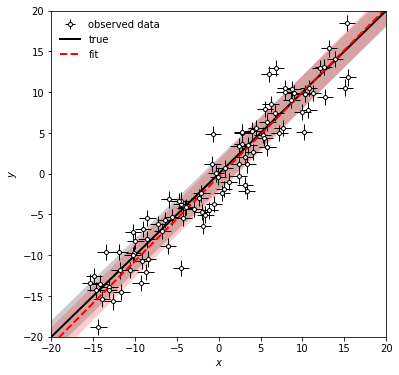

In [6]:
# visualization

fig, ax0 = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)

low_limit= -20
high_limit= 20

lo = ax0.errorbar(x, y, dy, dx, c='k', ls='', lw=1, marker='o', ms=4, mfc='w', label='observed data')
lt, = ax0.plot([low_limit,high_limit], [a_true+b_true*low_limit,a_true+b_true*high_limit], 
    c='k', lw=2, label='true')
ax0.fill_between([low_limit,high_limit], 
    [a_true+b_true*low_limit-sig_true,a_true+b_true*high_limit-sig_true],
    [a_true+b_true*low_limit+sig_true,a_true+b_true*high_limit+sig_true], fc='k', ec='none', alpha=0.2)
lf, = ax0.plot([low_limit,high_limit], [np.mean(a)+np.mean(b)*low_limit,np.mean(a)+np.mean(b)*high_limit], 
    c='r', lw=2, ls='--', label='fit')
plot_linear_fit_with_error(ax0, low_limit, high_limit, 0, 0, 
    np.mean(a), np.std(a), np.mean(b), np.std(b), np.mean(sig), np.std(sig),
    fc='r', ec='none', alpha=0.2)

# plot parameters
ax0.set_xlabel(r'$x$')
ax0.set_ylabel(r'$y$')
ax0.set_xlim(low_limit, high_limit)
ax0.set_ylim(low_limit, high_limit)

ax0.legend(handles=[lo, lt, lf], frameon=False)
plt.show()